In [50]:
import pandas as pd
data=pd.read_csv('/content/worldometer_coronavirus_daily_data.csv',parse_dates=['date'])
data=data[data['country']=='China'][:70].set_index('date')['cumulative_total_cases']

In [51]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

# Create sequences for the GRU model
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

seq_length = 3
X, y = create_sequences(scaled_data, seq_length)

# Split into training and testing sets
# train_size = int(len(X) * 0.8)
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, LSTM, Dropout


model = Sequential()
model.add(LSTM(units=200, return_sequences=True))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=200, return_sequences=False))  # Last timestep
model.add(Dropout(0.3))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 712ms/step - loss: 0.6047 - val_loss: 0.9084
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.5281 - val_loss: 0.7733
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.4520 - val_loss: 0.5425
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.3075 - val_loss: 0.2035
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0975 - val_loss: 0.0166
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0880 - val_loss: 0.1169
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1351 - val_loss: 0.0010
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0339 - val_loss: 0.0456
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0458 - val_loss: 0.1095
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0761 - val_loss: 0.1237
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0806 - val_loss: 0.0895
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0640 - val_loss: 0.0338

In [55]:
loss = model.evaluate(X, y)
print(f'Test Loss: {loss}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0022
Test Loss: 0.0017428427236154675


In [56]:
# Predict the next day
last_sequence = scaled_data[-seq_length:]
last_sequence = last_sequence.reshape((1, seq_length, 1))
next_day_prediction = model.predict(last_sequence)
next_day_price = scaler.inverse_transform(next_day_prediction)

print(f'Predicted next day price: {next_day_price[0][0]}')

# Predict the next week
predictions = []
current_sequence = last_sequence

for _ in range(15):
    next_day_prediction = model.predict(current_sequence)
    next_day_price = scaler.inverse_transform(next_day_prediction)
    predictions.append(next_day_price[0][0])
    current_sequence = np.append(current_sequence[:, 1:, :], next_day_prediction.reshape(1, 1, 1), axis=1)

print(f'Predicted prices for the next week: {predictions}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
Predicted next day price: 82208.109375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted prices for the next week: [82208.11, 82296.7, 82468.35, 82872.31, 82982.99, 83177.29, 83443.44, 83564.22, 83740.96, 83929.27, 84047.59, 84196.58, 84338.22, 84446.26, 84568.35]


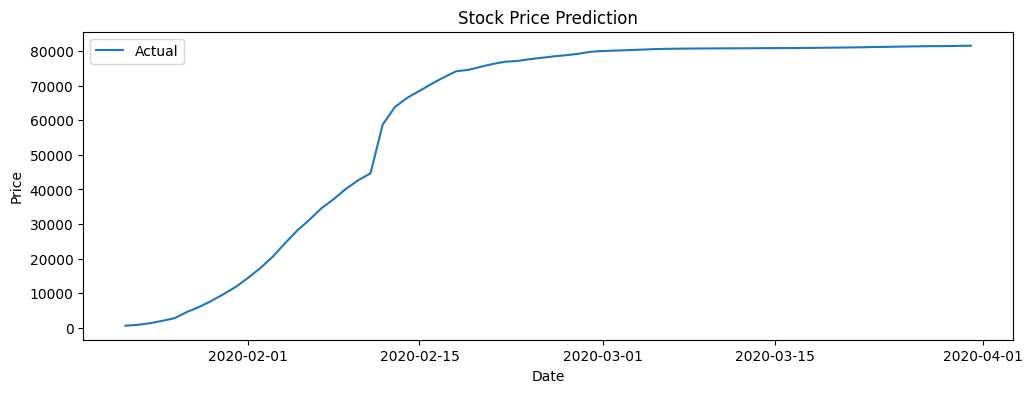

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12,4))
# plt.subplot(1, 3, 1)
# plt.plot(history.history['loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train'], loc='upper left')

# Plot actual vs predicted prices for past 60 days
plt.plot(data.index, data.values, label='Actual')
plt.plot(pd.date_range(start='2020-03-31', periods=15).tolist(), predictions, label='Predicted', color='r')
plt.title('Stock Price Prediction')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(['Actual', 'Predicted'], loc='upper left')

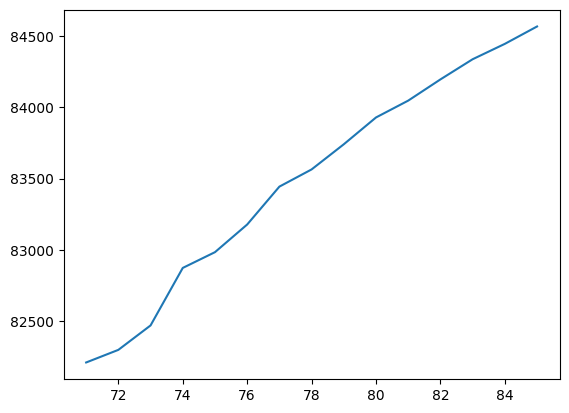